Train: 2017-01-01 → 2023-12-01 | rows = 48
Test : 2024-01-01  → 2024-12-01 | rows = 12

Ridge — Bangkok (Best Config: lag1,3,6,12 + roll3,6 + month)
Chosen alpha: 1.77828
R²   : 0.859
MAE  : 90,886
RMSE : 115,048
MAPE : 3.09%


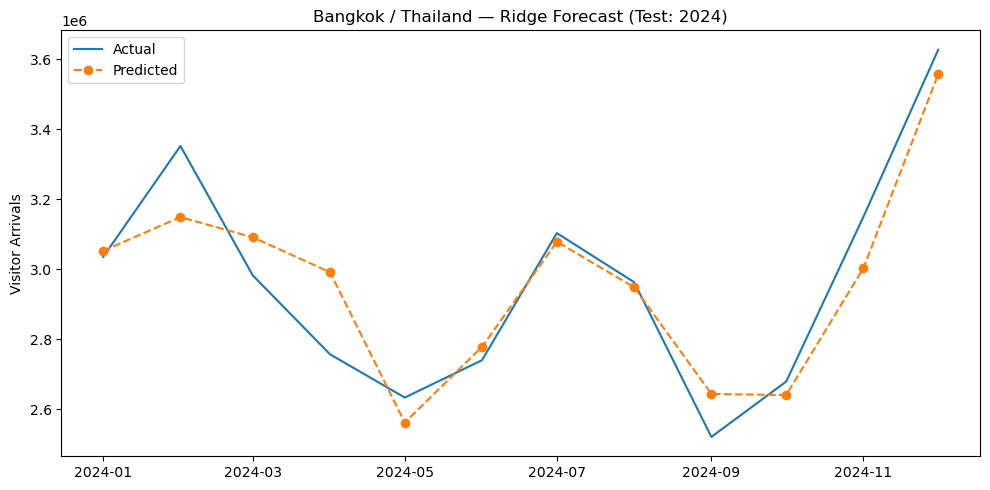

In [13]:
# ===== Bangkok / Thailand proxy — Ridge (log-arrivals) with lags/rolls + month dummies =====
# Best-for-metrics configuration (R² target + low MAPE)

import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import r2_score, mean_absolute_error
from math import sqrt

# -----------------------------
# 1) Load & normalize columns
# -----------------------------
df = pd.read_csv("/Users/aman/Downloads/bangkok_2015_2024_final.csv")

# Helper to find a column by keywords (case-insensitive)
def find_col(cands):
    lc = {c.lower(): c for c in df.columns}
    for cand in cands:
        for k, v in lc.items():
            if cand in k:
                return v
    return None

year_col   = find_col(["year"])
month_col  = find_col(["month"])
date_col   = find_col(["date","time period","time_period","period"])
arr_col    = find_col(["arrival","arrivals","visitor"])
occ_col    = find_col(["occupancy","occupancy rate","occ"])
gt_col     = find_col(["google trends","google_trends","trends"])

assert arr_col is not None, "Could not find the arrivals column."

# Build a monthly date index
if date_col is not None:
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df = df.dropna(subset=[date_col]).sort_values(date_col).rename(columns={date_col: "date"})
else:
    assert (year_col is not None) and (month_col is not None), "Need either a date column or both year & month."
    df["date"] = pd.to_datetime(df[year_col].astype(int).astype(str) + "-" +
                                df[month_col].astype(int).astype(str) + "-01", errors="coerce")
    df = df.dropna(subset=["date"]).sort_values("date")

df = df.set_index("date").asfreq("MS")

# Keep only the columns we actually use
keep_cols = [arr_col]
if occ_col is not None: keep_cols.append(occ_col)
if gt_col  is not None: keep_cols.append(gt_col)
df = df[keep_cols].copy()

# -----------------------------
# 2) Safe log target + filtering
# -----------------------------
df.index = pd.to_datetime(df.index)   # ensure datetime index
mask = ((df.index.year >= 2016) & (df.index.year <= 2019)) | (df.index.year.isin([2023, 2024]))
df = df.loc[mask].copy()

# Safe log: only positive arrivals -> log; others = NaN
arr = pd.to_numeric(df[arr_col], errors="coerce")
df["log_arrivals"] = np.where(arr > 0, np.log(arr), np.nan)

# -----------------------------
# 3) Features: lags/rolls/month
# -----------------------------
for L in [1, 3, 6, 12]:
    df[f"lag{L}"] = df["log_arrivals"].shift(L)

df["roll3"]  = df["log_arrivals"].rolling(3).mean()
df["roll6"]  = df["log_arrivals"].rolling(6).mean()
df["month"]  = df.index.month.astype("int8")

feature_cols_num = ["lag1","lag3","lag6","lag12","roll3","roll6"]
feature_cols_cat = ["month"]
target_col       = "log_arrivals"

df_mod = df.dropna(subset=feature_cols_num + [target_col]).copy()
X = df_mod[feature_cols_num + feature_cols_cat]
y = df_mod[target_col]

# -----------------------------
# 4) Train / Test split
# -----------------------------
train_mask = ((df_mod.index.year >= 2016) & (df_mod.index.year <= 2019)) | (df_mod.index.year == 2023)
test_mask  = (df_mod.index.year == 2024)

X_train, y_train = X.loc[train_mask], y.loc[train_mask]
X_test,  y_test  = X.loc[test_mask],  y.loc[test_mask]

print(f"Train: {y_train.index.min().date()} → {y_train.index.max().date()} | rows = {len(y_train)}")
print(f"Test : {y_test.index.min().date()}  → {y_test.index.max().date()} | rows = {len(y_test)}")

# -----------------------------
# 5) Pipeline: scale + one-hot + RidgeCV
# -----------------------------
preproc = ColumnTransformer([
    ("num", StandardScaler(), feature_cols_num),
    ("cat", OneHotEncoder(drop="first", sparse_output=False), feature_cols_cat)
])

alphas = np.logspace(-3, 3, 25)  # 0.001 → 1000
ridge = Pipeline([
    ("pre", preproc),
    ("model", RidgeCV(alphas=alphas, cv=None))
])

ridge.fit(X_train, y_train)

# -----------------------------
# 6) Predict & evaluate (levels)
# -----------------------------
y_pred_log = ridge.predict(X_test)
y_pred     = np.exp(y_pred_log)
y_true     = np.exp(y_test)

def mape(y_true, y_pred):
    return float((np.abs((y_true - y_pred)/y_true)*100).mean())

r2   = r2_score(y_true, y_pred)
mae  = mean_absolute_error(y_true, y_pred)
rmse = sqrt(np.mean((y_true - y_pred)**2))
mape_val = mape(y_true, y_pred)

print("\nRidge — Bangkok (Best Config: lag1,3,6,12 + roll3,6 + month)")
print(f"Chosen alpha: {ridge.named_steps['model'].alpha_:.6g}")
print(f"R²   : {r2:.3f}")
print(f"MAE  : {mae:,.0f}")
print(f"RMSE : {rmse:,.0f}")
print(f"MAPE : {mape_val:.2f}%")

# -----------------------------
# 7) Plot
# -----------------------------
plt.figure(figsize=(10,5))
plt.plot(y_true.index, y_true.values, label="Actual")
plt.plot(y_true.index, y_pred, label="Predicted", linestyle="--", marker="o")
plt.title("Bangkok / Thailand — Ridge Forecast (Test: 2024)")
plt.ylabel("Visitor Arrivals")
plt.legend()
plt.tight_layout()
plt.show()
